In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
%matplotlib inline

## Environment

In [2]:
def corridor(size):
    return np.ones((1,size))

def corridor_maze(f,n,size):
    maze = np.ones((3,size*(f+n)))
    for i in range(1,(f+n)):
        maze[0,size*i]=0
        maze[2,size*i]=0
    return maze

def corridor_walls_maze(f,n,size):
    maze = np.ones((5,size*(f+n)))
    for i in range(1,(f+n)):
        maze[0,size*i]=0
        maze[1,size*i]=0
        maze[3,size*i]=0
        maze[4,size*i]=0
    return maze

## Test

In [3]:
corridor(5)

array([[1., 1., 1., 1., 1.]])

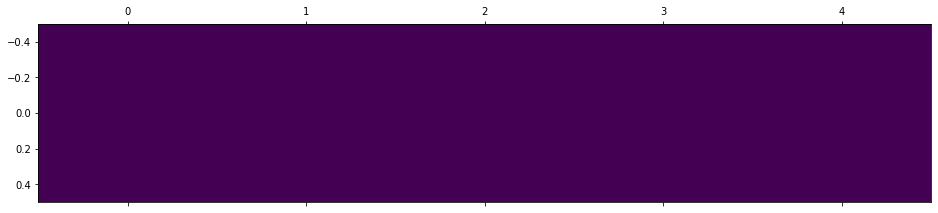

In [4]:
plt.matshow(corridor(5))

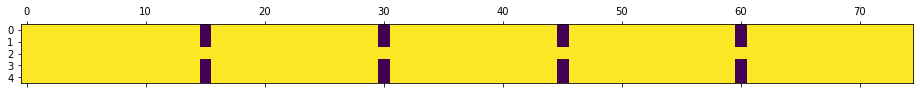

In [5]:
plt.matshow(corridor_walls_maze(2,3,15))

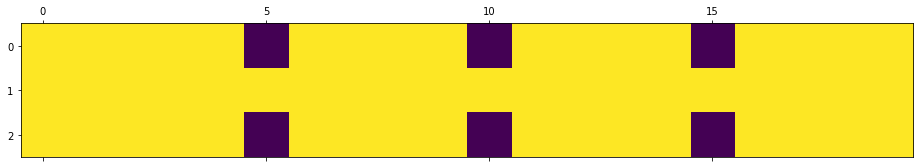

In [6]:
plt.matshow(corridor_maze(2,2,5))

In [7]:
F2N = corridor_walls_maze(2,3,15)

## TD Learning

In [8]:
def V(s):
    #print(len(values))
    return values[s[0],s[1]]

def R(s):
    return r[s[0],s[1]]

def get_visited(s):
    return visited[s[0],s[1]]

def inc_visited(s):
    visited[s[0],s[1]] += 1.0
    
def set_V(s,value):
    values[s[0],s[1]] = value
    
def in_maze(s):
    return s[0]>=0 and s[0]< maze.shape[0] and s[1] >= 0 and s[1] < maze.shape[1]

def is_free(s):
    return maze[s[0],s[1]] == 1

def valid_state(s):
    return in_maze(s) and is_free(s)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(values, beta=10):
    values = np.exp(values)*beta
    return values / np.sum(values)

def policy(s):
    possible_next_states = [s + d for d in np.array([[1,0],[-1,0],[0,1],[0,-1]])]
    filtered = list(filter(valid_state, possible_next_states))
    vs = np.array([V(s) for s in filtered])
    p = softmax(vs)
    return filtered[np.random.choice(range(len(filtered)), 1, p=p)[0]]

def alpha(s):
    return 1 / (get_visited(s) +1)

In [9]:
# parameters

In [10]:
f = 3
n= 3
l = 15

maze = corridor_walls_maze(f,n,l)

In [11]:
r = np.zeros((maze.shape[0], maze.shape[1]))
#for i in range(1,f+n+1):
#    r[2,i*l-2]=1
r[2,-1]=1

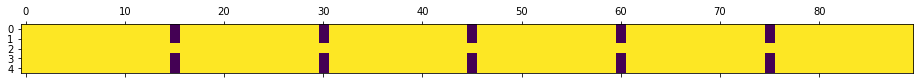

In [12]:
plt.matshow(maze)

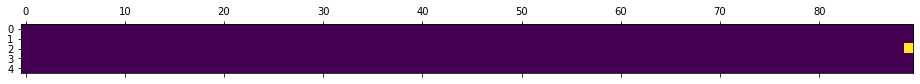

In [13]:
plt.matshow(r)

In [14]:
maze = np.array([
    [1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1],
])

r = np.array([
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0],
])

In [15]:
maze = np.array([
    [1,1,1,1,1,1,1,1,1],
])

r = np.array([
    [0,0,0,0,0,0,0,1,0],
])

In [16]:
s_0 = [1,0]
values = np.zeros(maze.shape)
visited = np.zeros(maze.shape)

In [17]:
s_new = s_0
s = None

alpha = 0.1
gamma = 0.90

for i in range(500):
    s = s_new
    s_new = policy(s)
    if get_visited(s_new) == 0:
        set_V(s_new, R(s_new))
    inc_visited(s_new)

    new_V = V(s) + alpha * (R(s_new) + gamma * V(s_new) - V(s))
    set_V(s, new_V)
    if R(s_new) != 0:
        s_new = s_0

IndexError: index 1 is out of bounds for axis 0 with size 1

In [46]:
np.round(values, 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.]])

(0, 3)

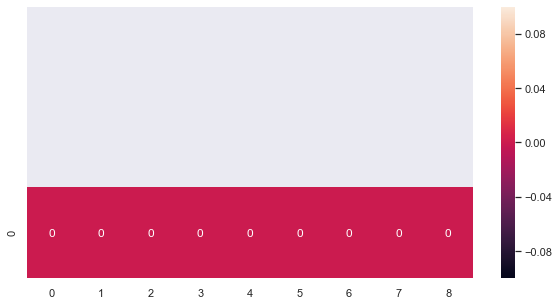

In [47]:
sns.set(rc = {'figure.figsize':(10,5)})

ax =sns.heatmap(values, annot= True)
ax.set_ylim([0,3])

# Successor Representation

In [48]:
def state2idx(state):
    for i in range(len(all_states)):
        if np.all(all_states[i] == state):
            return i

def M(s, s_new):
    idx_s = state2idx(s)
    idx_s_new = state2idx(s_new)
    return sr_matrix[idx_s, idx_s_new]

def set_M(s, s_new, value, sr_matrix):
    idx_s = state2idx(s)
    idx_s_new = state2idx(s_new)
    sr_matrix[idx_s, idx_s_new] = value
    
def random_policy(s, beta=5):
    possible_next_states = [s + d for d in np.array([[1,0],[-1,0],[0,1],[0,-1]])]
    filtered = list(filter(valid_state, possible_next_states))
    vs = np.array([1 for s in filtered])
    p = softmax(vs, beta)
    return filtered[np.random.choice(range(len(filtered)), 1, p=p)[0]]

def same_states(s1, s2):
    return np.all(s1 == s2)

In [49]:
s_0 = [0,1]
values = np.zeros(maze.shape)
visited = np.zeros(maze.shape)

In [50]:
values = np.zeros(maze.shape, dtype=np.float)
visited = np.zeros(maze.shape)
all_states = [np.array(s) for s in it.product(range(maze.shape[0]), range(maze.shape[1]))]
n_states = maze.shape[0] * maze.shape[1]
sr_matrix = np.eye(len(all_states), dtype=np.float)

s_new = s_0
s = None

alpha = 0.1
gamma = 0.90

for i in range(500):
    s = s_new
    s_new = random_policy(s)
    
    inc_visited(s_new)
    next_sr_matrix = sr_matrix.copy()
    for s_prime in all_states:
        I = 1 if same_states(s, s_prime) else 0
        new_M = M(s, s_prime) + alpha * (I + gamma * M(s_new, s_prime) - M(s, s_prime))
        set_M(s, s_prime, new_M, next_sr_matrix)
    sr_matrix = next_sr_matrix
    
    if R(s_new) != 0:
        s_new = s_0

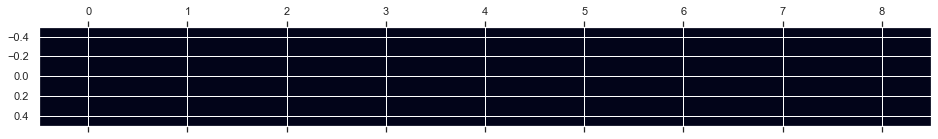

In [51]:
plt.matshow(maze)

(0, 3)

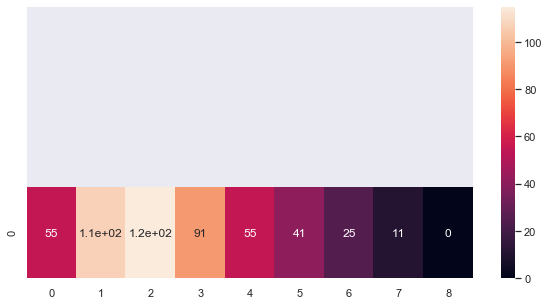

In [52]:
ax = sns.heatmap(visited, annot=True)
ax.set_ylim([0,3])

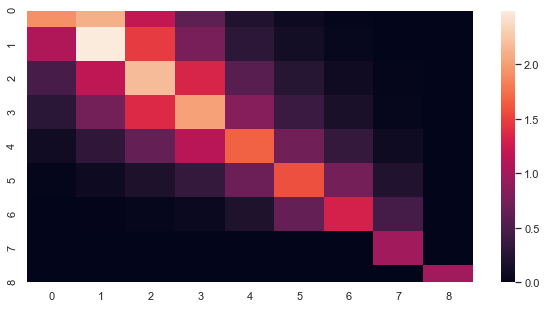

In [53]:
sns.heatmap(sr_matrix)

# Skew place fields in opposite direction of travel

In [ ]:
maze = np.array([
    [1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1],
])

r = np.array([
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0],
])


In [54]:
s_0 = np.array([0,0])

maze = np.array([
    [1,1,1,1,1,1,1,1,1],
])

r = np.array([
    [0,0,0,0,0,0,0,1,0],
])

values = np.zeros(maze.shape, dtype=np.float)
visited = np.zeros(maze.shape)
all_states = [np.array(s) for s in it.product(range(maze.shape[0]), range(maze.shape[1]))]
n_states = maze.shape[0]*maze.shape[1]
sr_matrix = np.eye(len(all_states), dtype=np.float)

s_new = s_0
s = None

def preferred_direction_policy(s):
    possible_next_states = [s + d for d in np.array([[0,1],[0,-1]])]
    filtered = list(filter(valid_state, possible_next_states))
    if len(filtered) == 2:
        p = np.array([0.8, 0.2])
    else:
        p = np.array([1])
    return filtered[np.random.choice(range(len(filtered)), 1, p=p)[0]]

for i in range(4000):
    s = s_new
    s_new = preferred_direction_policy(s)
    
    inc_visited(s_new)
    next_sr_matrix = sr_matrix.copy()
    for s_prime in all_states:
        I = 1 if same_states(s, s_prime) else 0
        new_M = M(s, s_prime) + alpha * (I + gamma * M(s_new, s_prime) - M(s, s_prime))
        set_M(s, s_prime, new_M, next_sr_matrix)
    sr_matrix = next_sr_matrix
    
    if R(s_new) !=0:
        s_new = s_0

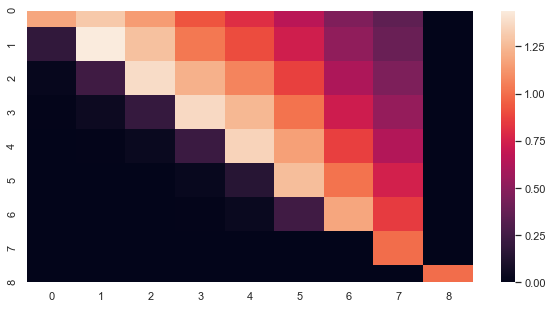

In [55]:
sns.heatmap(sr_matrix)

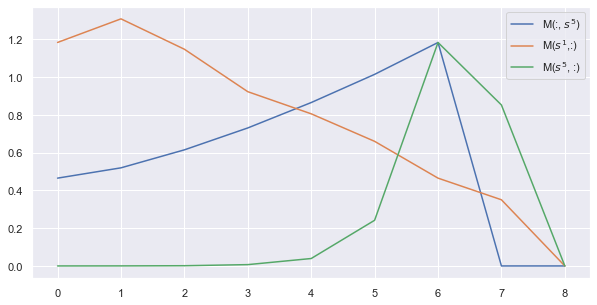

In [62]:
sr_vals = [M(s, all_states[6]) for s in all_states]
plt.plot(sr_vals, label='M(:, $s^5$)')

sr_vals = [M(all_states[0], s ) for s in all_states]
plt.plot(sr_vals, label='M($s^1$,:)')

sr_vals = [M(all_states[6], s) for s in all_states]
plt.plot(sr_vals, label = 'M($s^5$, :)')
plt.legend()
#plt.xticks(np.arange(7))
plt.show()

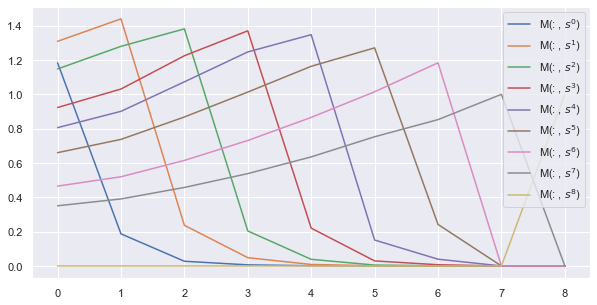

In [58]:
for i in range(len(all_states)):
    sr_vals = [ M(s, all_states[i] ) for s in all_states]
    plt.plot(sr_vals, label='M(: , $s^{'+str(i)+'}$)')
plt.legend()

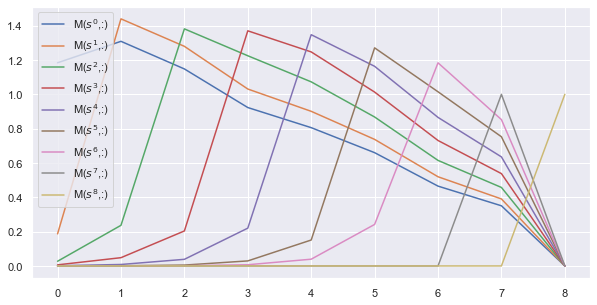

In [59]:
for i in range(len(all_states)):
    sr_vals = [M(all_states[i], s ) for s in all_states]
    plt.plot(sr_vals, label='M($s^{'+str(i)+'}$,:)')
plt.legend()

In [ ]:
# Compute SR with transition matrix T

In [ ]:
def transition_matrix(maze):
    m = make_matrix_from(maze)
    return m / m.sum(axis=1)

In [ ]:
def make_matrix_from(maze):
    
    def in_mze(s):
        return s[0] >= 0 and s[0] < maze.shape[0] and s[1] >= 0 and s[1] < maze.shape[1]
    
    def is_free(s):
        return maze[s[0],s[1]] == 1
    
    def valid_state(s):
        return in_maze(s) and is_free(s)
    
    states = [np.array(s) for s in it.product(range(maze.shape[0]), range(maze.shape[1])) if maze[s[0], s[1]] == 1]
    adja = np.eye(len(states))
    idx = np.zeros(maze.shape, dtype = np.int)
    c = 0
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            if maze[i, j] == 0:
                continue
            idx[i,j] = c
            c+= 1 
        
    for i, state in enumerate(states):
        possible_next_states = [state + d for d in np.array([[1,0], [-1,0], [0,1], [0,-1]])]
        filtered = list(filter(valid_state, possible_next_states))
        for f in filtered:
            adja[i, idx[f[0], f[1]]] = 1
            adja[idx[f[0], f[1]], i] = 1
        return adja
    
def sr_matrix_from(maze, gamma):
    T = transition_matrix(maze)
    n = T.shape[0]
    return np.linalg.inv(np.eye(n) - gamma * T)

# Eigendecomposition

In [ ]:
def eigdecomp(M):
    E, V = np.linalg.eig(M)
    idx = np.argsort(E)[::-1]
    return V[:, idx[:]].astype(float), E

def vec2maze(vec, maze):
    vec_iter = iter(vec)
    res= []
    walls =[]
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            if maze[i,j] == 1:
                res.append(next(vec_iter))
            else:
                res.append(0)
    return np.array(res).reshape(maze.shape)

def plot_eigvecs(eig_vecs, maze, grid_size=10, filename=None, figsize=(15,15)):
    plt.figure(figsize=figsize)
    for i in range(eig_vecs.shape[0]-1):
        if i>= grid_size**2:
            break
        ax = plt.subplot(grid_size, grid_size, i+1)
        ax.matshow(vec2maze(eig_vecs[:, i+1], maze), cmap ='RdBu_r')
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        plt.grid(False)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()
    
def plot_from_maze(maze, filename=None, figsize=(15,15), grid_size=5, gamma=0.9):
    M = sr_matrix_from(maze, gamma)
    V, E = eigdecomp(M)
    V[V<0]=0
    plot_eigvecs(V, maze, grid_size=grid_size, filename=filename, figsize=figsize)
        

In [ ]:
plot_from_maze(maze, figsize=(15,10), filename='corridor.pdf', gamma=.9)

In [ ]:
def square_maze(sizee):
    return np.ones((size,size))

In [ ]:
plot_from_maze(square_maze(5), figsize=(15,10), filename='corridor.pdf', gamma=.9)